In [1]:
import sys
sys.path.append('/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages')


In [1]:
import os
import json
import shutil
from tqdm import tqdm
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch


In [2]:
# Define dataset base paths
bdd_root = "/projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco"
train_json = os.path.join(bdd_root, "ann", "train.json")
val_json = os.path.join(bdd_root, "ann", "val.json")
test_json = os.path.join(bdd_root, "ann", "test.json")  

# Image folders
train_images = os.path.join(bdd_root, "images", "train")
val_images = os.path.join(bdd_root, "images", "val")
test_images = os.path.join(bdd_root, "images", "test")  

# Output label directories (YOLO format)
yolo_label_root = "/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/labels"
yolo_train_labels = os.path.join(yolo_label_root, "train")
yolo_val_labels = os.path.join(yolo_label_root, "val")
yolo_test_labels = os.path.join(yolo_label_root, "test")  # Added test label path

# Ensure label directories exist
os.makedirs(yolo_train_labels, exist_ok=True)
os.makedirs(yolo_val_labels, exist_ok=True)
os.makedirs(yolo_test_labels, exist_ok=True)

# YOLOv5 image structure
yolo_image_root = "/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images"
yolo_train_images = os.path.join(yolo_image_root, "train")
yolo_val_images = os.path.join(yolo_image_root, "val")
yolo_test_images = os.path.join(yolo_image_root, "test")  # Added test image path

# Ensure image directories exist
os.makedirs(yolo_train_images, exist_ok=True)
os.makedirs(yolo_val_images, exist_ok=True)
os.makedirs(yolo_test_images, exist_ok=True)


In [3]:
def convert_bbox_to_yolo(x, y, w, h, img_w, img_h):
    cx = x + w / 2
    cy = y + h / 2
    return cx / img_w, cy / img_h, w / img_w, h / img_h

def process_coco_json(json_path, img_dir, label_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)

    img_id_to_file = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_size = {img['id']: (img['width'], img['height']) for img in data['images']}
    
    annotations_by_image = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        annotations_by_image.setdefault(img_id, []).append(ann)

    for img_id, anns in tqdm(annotations_by_image.items(), desc=f"Converting {os.path.basename(json_path)}"):
        file_name = img_id_to_file[img_id]
        width, height = img_id_to_size[img_id]
        txt_name = file_name.replace('.jpg', '.txt')
        txt_path = os.path.join(label_dir, txt_name)

        lines = []
        for ann in anns:
            category_id = ann['category_id'] - 1  # YOLO expects 0-based indexing
            x, y, w, h = ann['bbox']
            yolo_bbox = convert_bbox_to_yolo(x, y, w, h, width, height)
            lines.append(f"{category_id} {' '.join(f'{c:.6f}' for c in yolo_bbox)}")

        with open(txt_path, 'w') as f:
            f.write('\n'.join(lines))

# Run conversion for all splits
process_coco_json(train_json, train_images, yolo_train_labels)
process_coco_json(val_json, val_images, yolo_val_labels)
process_coco_json(test_json, test_images, yolo_test_labels)


Converting test.json: 100%|██████████| 19996/19996 [01:02<00:00, 317.67it/s]


In [4]:
def copy_images(image_dir, label_dir, output_dir):
    label_files = os.listdir(label_dir)
    for label_file in tqdm(label_files, desc=f"Copying images to {os.path.basename(output_dir)}"):
        image_name = label_file.replace(".txt", ".jpg")
        src_path = os.path.join(image_dir, image_name)
        dst_path = os.path.join(output_dir, image_name)

        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)

# Copy images for all splits
copy_images(train_images, yolo_train_labels, yolo_train_images)
copy_images(val_images, yolo_val_labels, yolo_val_images)
copy_images(test_images, yolo_test_labels, yolo_test_images)


Copying images to test: 100%|██████████| 19996/19996 [02:19<00:00, 142.94it/s]


In [8]:
import subprocess

# Custom YAML dataset config
data_yaml = "/projects/academic/courses/cse676su25/ritikver/yolo/bdd.yaml"

# Train command
train_command = [
    "python", "/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "20",
    "--data", data_yaml,
    "--weights", "", 
    "--workers", "0",
    "--cfg", "/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/models/yolov5s.yaml",
    "--project", "runs/train",
    "--name", "bdd_yolov5",
    "--exist-ok"
]

# Run training
subprocess.run(train_command)


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/compat/usr/lib/python3.10/site-packages/certifi/_patch.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
train: weights=, cfg=/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/models/yolov5s.yaml, data=/projects/academic/courses/cse676su25/ritikver/yolo/bdd.yaml, hyp=../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=../yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs/train, name=bdd_yolov5, exist_ok=True, quad=False, cos_lr=False, label_smoot

CompletedProcess(args=['python', '/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/train.py', '--img', '640', '--batch', '16', '--epochs', '20', '--data', '/projects/academic/courses/cse676su25/ritikver/yolo/bdd.yaml', '--weights', '', '--workers', '0', '--cfg', '/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/models/yolov5s.yaml', '--project', 'runs/train', '--name', 'bdd_yolov5', '--exist-ok'], returncode=-9)

In [12]:
import shutil
import random

# Source: full test image dir
full_test_dir = "/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images/test"
sampled_test_dir = "/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images/test_1k"

# Make sure target dir exists
os.makedirs(sampled_test_dir, exist_ok=True)

# Pick 1000 random image files (only .jpg assumed)
all_images = [f for f in os.listdir(full_test_dir) if f.endswith(".jpg")]
sampled_images = random.sample(all_images, k=1000)

# Copy selected images
for img_file in sampled_images:
    shutil.copy2(os.path.join(full_test_dir, img_file), os.path.join(sampled_test_dir, img_file))


In [16]:
import subprocess
import os

# Inference settings
weights_path = "runs/train/bdd_yolov5/weights/yolov5s.pt"  
test_dir = "/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images/test_1k"
output_dir = "yolo_test_predictions"

# Make output directory
os.makedirs(output_dir, exist_ok=True)

# Run inference using detect.py on test set
inference_command = [
    "python", "/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/detect.py",
    "--weights", weights_path,
    "--img", "640",
    "--conf", "0.25",
    "--source", test_dir,
    "--project", output_dir,
    "--name", "predictions",
    "--save-txt",
    "--exist-ok"
]

# Execute command
subprocess.run(inference_command)


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/compat/usr/lib/python3.10/site-packages/certifi/_patch.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
detect: weights=['runs/train/bdd_yolov5/weights/yolov5s.pt'], source=/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images/test_1k, data=../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolo_test_predictions, name=predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4

CompletedProcess(args=['python', '/projects/academic/courses/cse676su25/ritikver/yolo/yolov5/detect.py', '--weights', 'runs/train/bdd_yolov5/weights/yolov5s.pt', '--img', '640', '--conf', '0.25', '--source', '/projects/academic/courses/cse676su25/ritikver/yolo/yolo_notebook/images/test_1k', '--project', 'yolo_test_predictions', '--name', 'predictions', '--save-txt', '--exist-ok'], returncode=0)

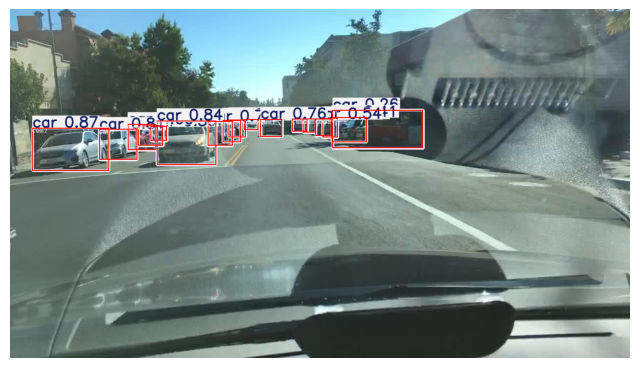

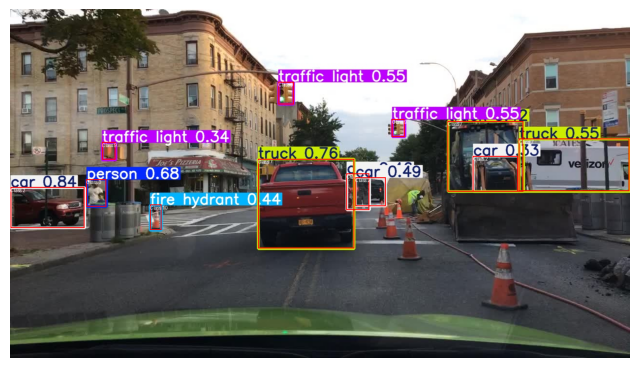

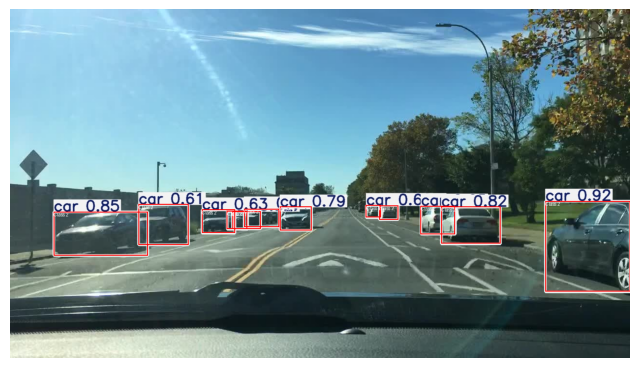

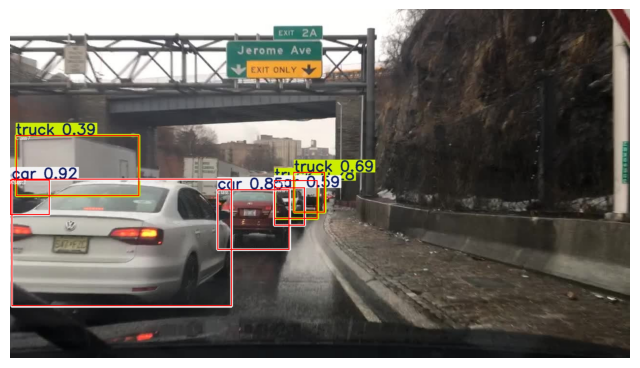

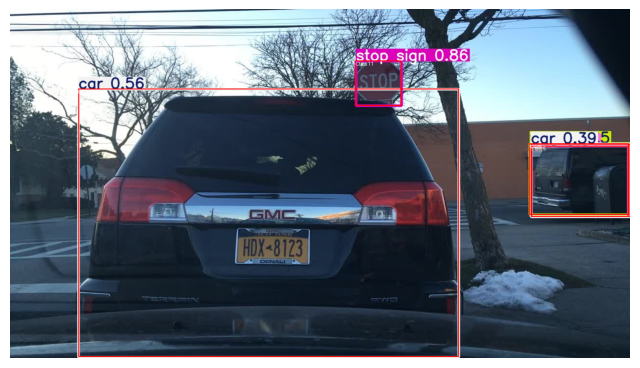

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import random
import os

# Folder where YOLO saves predictions
pred_dir = "yolo_test_predictions/predictions/labels"
img_dir = "yolo_test_predictions/predictions"

# Pick a few random prediction files
pred_files = random.sample(os.listdir(pred_dir), k=5)

def plot_image_with_boxes(img_path, label_path):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls, cx, cy, w, h = map(float, parts)
            img_w, img_h = img.size
            x1 = (cx - w / 2) * img_w
            y1 = (cy - h / 2) * img_h
            x2 = (cx + w / 2) * img_w
            y2 = (cy + h / 2) * img_h
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            draw.text((x1, y1), f"Class {int(cls)}", fill='white')

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display predictions
for pred_file in pred_files:
    label_path = os.path.join(pred_dir, pred_file)
    img_path = os.path.join(img_dir, pred_file.replace('.txt', '.jpg'))
    if os.path.exists(img_path):
        plot_image_with_boxes(img_path, label_path)
